# 최종2. Prepare Dataset & Default Train

# Index
### 1. 4가지 Dataset 준비
### 2. 각 Dataset 별 Default Hyper-Paramter Train (for 모델 선정)
### 3. 각 Dataset 별 잘못 예측된 이미지 열람 (for get Idea about Pipeline)

## 1. 4가지 Dataset 준비
- 1-1. Original MNIST -> Train / Validation # 10 classes
- 1-2. Handmade MNIST -> Train / Validation # 10 classes, 15 classes
- 1-3. Combined MNIST -> Original + Handmade # 10 classes
- 1-4. Combined MNIST -> Original + Handmade # 15 classes 

## 1-1. Original MNIST -> Train / Validation
- 0.8:0.2 비율로 분할 // train_test_split

In [1]:
import pickle
# 미리 피클 라이브러리를 활용해 저장해둔 MNIST 불러오기
# 매번 fetch 하기 오래 걸려서 채택
from sklearn.model_selection import train_test_split
filename = 'mnist_data.pkl'
with open(filename, 'rb') as f:
    mnist = pickle.load(f)

X_original = mnist.data.astype('float32')
X_original = X_original/255.0
y_original = mnist.target

o_X_train, o_X_test, o_y_train, o_y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)
print(o_X_train.shape, o_X_test.shape, o_y_train.shape, o_y_test.shape)

(56000, 784) (14000, 784) (56000,) (14000,)


## 1-2. Handmade MNIST -> Train / Validation
- (0~9, +, -, x, / , =) 15개 라벨이 아닌 모든 데이터 삭제
- 육안으로 데이터 클리닝 -> Index 저장
- 저장했던 삭제할 Index에 해당하는 데이터 삭제
- Test Dataset은 프로젝트 마무리 단계에서 한번만 사용
- TrainVal Data 0.8:0.2 비율로 분할 // train_test_split
- 삭제 작업을 진행하면 Index 혼동의 문제가 있어, 15 class 제작 후, (0~9) 10개 라벨이 아닌 모든 데이터 삭제 하여 10 class 제작

In [2]:
# import library for 이미지 가공
from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2

# Data Load // Data 디렉토리 아래 파일이 있어야 함
digit_data_trval=np.load('Data/digit_data_TrVal-1.npz')
digit_data_test=np.load('Data/digit_data_10_Test_1.npz')
op_data_trval=np.load('Data/op_data_TrVal-1.npz')
op_data_test=np.load('Data/op_data_10_Test_1.npz')

# train set 이미지와 레이블 추출
op_trval_images = op_data_trval['img']
op_trval_labels = op_data_trval['label']
digit_trval_images = digit_data_trval['img']
digit_trval_labels  = digit_data_trval['label']

# train set 이미지와 레이블 합치기
merged_trval_images =  list(digit_trval_images) + list(op_trval_images) 
merged_trval_labels =  list(digit_trval_labels) + list(op_trval_labels)


# test set 이미지와 레이블 추출
op_test_images = op_data_test['img']
op_test_labels = op_data_test['label']
digit_test_images = digit_data_test['img']
digit_test_labels  = digit_data_test['label']

# test 이미지와 레이블 합치기
merged_test_images = list(op_test_images) + list(digit_test_images)
merged_test_labels = list(op_test_labels) + list(digit_test_labels)

merged_trval_images = np.array(merged_trval_images)
merged_test_images = np.array(merged_test_images)

# 이미지를 1차원으로 변환
merged_trval_images_flat = merged_trval_images.reshape(merged_trval_images.shape[0], -1)
merged_test_images_flat = merged_test_images.reshape(merged_test_images.shape[0], -1)

valid_labels = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '/', 'x','='])

# 숫자 및 연산 기호가 아닌 데이터의 인덱스 찾기
invalid_trval_indices = [i for i, label in enumerate(merged_trval_labels) if label not in valid_labels]
invalid_test_indices = [i for i, label in enumerate(merged_test_labels) if label not in valid_labels]

# 숫자 및 연산 기호가 아닌 데이터 제거
d_X_train = np.delete(merged_trval_images_flat, invalid_trval_indices, axis=0)
d_y_train = np.delete(merged_trval_labels, invalid_trval_indices)

d_X_test = np.delete(merged_test_images_flat, invalid_test_indices, axis=0)
d_y_test = np.delete(merged_test_labels, invalid_test_indices)

# 데이터는 셔플 되어 있다고 가정
from collections import defaultdict

# 각 레이블별 인덱스 추출
label_indices_train = defaultdict(list)
label_indices_test = defaultdict(list)

# Train set에서 각 레이블별 인덱스 추출
for idx, label in enumerate(d_y_train):
    label_indices_train[label].append(idx)

# Test set에서 각 레이블별 인덱스 추출
for idx, label in enumerate(d_y_test):
    label_indices_test[label].append(idx)

size=10
    
# 각 레이블별로 train set은 400개, test set은 70개로 제한
selected_indices_train = []
selected_indices_test = []

for label, indices in label_indices_train.items():
    selected_indices_train.extend(indices[:int(420*size)])

for label, indices in label_indices_test.items():
    selected_indices_test.extend(indices[:int(70*size)])

# 선택된 인덱스로부터 데이터 구성
X_train = d_X_train[selected_indices_train]
y_train = d_y_train[selected_indices_train]

X_test = d_X_test[selected_indices_test]
y_test = d_y_test[selected_indices_test]

# 모델 선정용 데이터 shape 확인
print("잘못된 라벨링 삭제 전:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# 모델 선정용 데이터 절감 비율 확인
train_reduction_ratio = round(d_y_train.shape[0] / y_train.shape[0], 2)
test_reduction_ratio =  round(d_y_test.shape[0] / y_test.shape[0], 2)

# 라벨리 틀린 Index: Wrong,
# 학습에 애매한 Index: Vague, 각 index 별로 삭제

indices_wrong_10000=[2998,3018,3053,3057,3099,3102,3110,3138,3216,3220,3222,3248,3254,3268,3282,3292,3301,3307,3312,3335,3337,3368,3394,3459,3493,3510,3621,3651,3659,3690,3781,3784,3797,3800,3860,3861,3927,3934,3987,3991,4035,4036,4066,4080,4102,4154,4171,4192,4244,4319,4368,4387,4393,4420,4421,4422,4423,4424,4425,4426,4427,4428,4429,4430,4431,4432,4433,4434,4435,4436,4437,4438,4439,4440,4441,4442,4443,4444,4445,4446,4447,4448,
7432,7457,7466,7504,7532,7579,7580,7633,7640,7674,7702,7764,7772,7861,7870,7877,7898,7933,7954,7964,7967,7986,8017,8018,8040,8043,8047,8064,8082,8083,8095,8132,8133,8188,8195,8202,8204,8211,8267,8295,8317,8335,8336,8373,8381,8458,8482,8485,8520,8542,8551,8565,8568,8580,8706,8716,8734,8790,8791,8792,8793,8794,8795,8796,8797,8798,8799,8800,8801,8802,8803,8804,8805,8806,8807,8808,8809,8810,8811,8812,
5964,5976,6104,6123,6163,6169,6181,6189,6200,6261,6283,6301,6310,6318,6320,6348,6366,6383,6394,6416,6421,6435,6586,6632,6640,6742,6791,6802,6804,6808,6832,6840,6897,6926,6945,6987,6998,7005,7023,7032,7060,7088,7165,7166,7199,7231,7246,7276,7286,7292,7318,7346,7364,7365,7366,7367,7368,7369,7370,7371,7372,7373,7374,7375,7376,7377,7378,7379,7380,7381,7382,7383,7384,7385,7386,7387,7388,7389,7390,
4449,4461,4474,4483,4506,4510,4522,4570,4584,4600,4603,4667,4668,4671,4673,4693,4700,4749,4768,4879,4936,4964,5002,5011,5045,5082,5100,5130,5132,5152,5167,5184,5190,5201,5216,5290,5305,5316,5317,5320,5324,5349,5359,5373,5381,5393,5406,5415,5466,5504,5507,5525,5544,5581,5583,5595,5634,5639,5669,5679,5711,5719,5728,5729,5781,5818,5840,5850,5861,5890,5891,5892,5893,5894,5895,5896,5897,5898,5899,5900,5901,5902,5903,5904,5905,5906,5907,5908,5909,5910,5911,5912,5913,5914,5915,
6,9,13,98,191,207,228,244,252,262,267,274,289,364,395,404,421,456,501,529,544,552,561,571,599,637,653,683,710,740,787,843,845,870,892,893,921,932,933,957,990,992,1019,1062,1101,1122,1142,1150,1181,1188,1213,1276,1277,1286,1308,1316,1371,1405,1436,1454,1458,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,
8824,8831,8832,8849,8914,8932,8932,8934,8956,8968,8985,9011,9096,9111,9118,9175,9188,9214,9227,9229,9254,9302,9302,9320,9322,9324,9340,9354,9398,9440,9474,9488,9489,9491,9495,9534,9550,9558,9561,9565,9570,9574,9592,9618,9628,9629,9650,9675,9678,9704,9736,9875,9960,9970,
1486,1536,1558,1573,1621,1618,1647,1649,1669,1679,1696,1712,1812,1815,1833,1857,1916,1941,1986,1993,1999,2046,2084,2088,2092,2140,2186,2229,2257,2295,2299,2353,2357,2363,2366,2374,2386,2420,2470,2497,2502,2513,2517,2542,2551,2571,2574,2588,2590,2609,2621,2651,2664,2687,2689,2693,2725,2733,2736,2739,2761,281,2784,2787,2874,2906,2910,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954
]

indices_vague_10000=[
2995,3040,3181,3440,3452,3617,3627,3668,3688,3753,3779,3788,3827,3852,3888,3964,3993,4055,4083,4093,4151,4161,4174,4274,4331,4412,
7416,7477,7616,7644,8125,8179,8257,8263,8291,8301,8334,8395,8505,8544,8590,8651,
5949,6064,6119,6126,6214,6306,6314,6388,6463,6523,6536,6598,6610,6771,6796,6815,6940,7007,7049,7076,7222,7254,7344,7357,
4467,4540,4550,4635,4666,4710,4725,4742,4758,4783,4797,4800,4802,4829,4831,4870,4872,4881,4901,4914,4923,5003,5007,5016,5028,5061,5096,5182,5195,5206,5372,5374,5408,5414,5422,5453,5537,5548,5562,5598,5603,5612,5629,5659,5663,5673,5706,5707,5713,5717,5750,5751,5822,5831,5857,5862,
60,78,80,83,90,137,159,161,182,243,249,331,352,354,389,410,438,554,579,649,700,716,754,822,853,879,881,955,975,986,1078,1164,1198,1249,1260,1324,1337,1343,1395,1398,
8814,8883,8892,8908,8926,8971,8992,9030,9045,9088,9098,9104,9114,9231,9286,9291,9392,9409,9427,9438,9513,9516,9598,9699,9732,9751,9812,9817,9819,9838,9848,9868,9884,9956,9980,
1500,1519,1526,1532,1601,1603,1620,1632,1636,1654,1671,1732,1751,1786,1788,1798,1841,1855,1876,1924,1925,1972,1976,1978,1980,1994,2031,2070,2074,2104,2127,2154,2202,2203,2207,2218,2226,2241,2251,2297,2323,2406,2424,2429,2439,2449,2473,2577,2586,2595,2613,2617,2629,2679,2684,2770,2790,2888
]

indices_delete_10000 = indices_wrong_10000 + indices_vague_10000

for i in range(len(indices_delete_10000)):
    if indices_delete_10000[i] >= 4449:
        indices_delete_10000[i] += 3041

indices_delete_10000.extend([
    4464, 4482, 4493, 4495, 4490, 4502, 4508, 4520, 4526, 4527, 4529, 4545,
    4567, 4576, 4599, 4610, 4623, 4655, 4679, 4710, 4719, 4723, 4734, 4738,
    4763, 4770, 4792, 4795, 4831, 4868, 4874, 4903, 4919, 4940, 4971, 4982,
    5067, 5091, 5104, 5112, 5130, 5142, 5150, 5182, 5192, 5223, 5230, 5248,
    5262, 5273, 5284, 5296, 5301, 5308, 5310, 5322, 5347, 5349, 5429, 5462,
    5510, 5523, 5524, 5531, 5542, 5546, 5586, 5639, 5648, 5669, 5672, 5680,
    5685, 5687, 5721, 5725, 5740, 5755, 5768, 5781, 5861, 5865, 5900, 5904,
    5923, 5963, 5967, 5981, 5991, 5994, 6028, 6038, 6045, 6068, 6150, 6165,
    6184, 6215, 6218, 6245, 6268, 6276, 6294, 6300, 6390, 6422, 6441, 6501,
    6512, 6566, 6577, 6591, 6603, 6608, 6613, 6617, 6671, 6672, 6683, 6690,
    6731, 6768, 6792, 6808, 6822, 6833, 6857, 6880, 6900, 6901, 6920, 6971,
    6987, 7005, 7013, 7034, 7038, 7058, 7064, 7084, 7094, 7098, 7168, 7170,
    7178, 7186, 7189, 7203, 7210, 7213, 7231, 7242, 7245, 7246, 7260, 7272,
    7308, 7316, 7320, 7324, 7350, 7353, 7361, 7383, 7394, 7397, 7398, 7412,
    7415, 7444, 7453, 7465
])

indices_wrong_10000_20000 = [
    1828, 1833, 1850, 1874, 1877, 1878, 1882, 1883, 1889, 1891, 1924, 1937, 1945, 1952,
    1960, 1961, 1973, 1979, 2012, 2025, 2041, 2087, 2135, 2193, 2206, 2306, 2341, 2431,
    2434, 2482, 2522, 2633, 2642, 2656, 2671, 2678, 2786, 2687, 2744, 2844, 2860, 2893, 2940,
    2969, 2991, 3271, 3282, 3311, 3334, 3352, 3424, 3436, 3575, 3579, 3600, 3697, 3735, 3845,
    3853, 3915, 3947, 3953, 3967, 4006, 4038, 4053, 3058, 4101, 4103, 4107, 4131, 4156, 4183,
    4185, 4195, 4239, 4241, 4277, 4288, 4290, 4308, 4375, 4402, 4410, 4420, 4445, 4484, 4539,
    4625, 4639, 4654, 4682, 4708, 4729, 4778, 4807, 6399, 6406, 6434, 6455, 6457, 6469, 6502,
    6543, 6544, 6547, 6559, 6577, 6659, 6679, 6752, 6762, 6801, 6837, 6841, 6849, 6929, 6974,
    6988, 7075, 7106, 7128, 7141, 7162, 7239, 7267, 7298, 7305, 7312, 7345, 7346, 7348, 7370,
    7375, 7417, 7453, 7479, 7516, 7528, 7557, 7608, 7611, 7663, 7726, 7760, 7795, 7836, 7844,
    7890, 7943, 7992, 8018, 8055, 8082, 8120, 8129, 8314, 8350, 8416, 8419, 8471, 8487, 8568,
    8577, 8669, 8702, 8814, 8823, 8827, 8847, 8896, 8938, 9061, 9068, 9196, 9205, 9278, 9279,
    4904, 4984, 4998, 5012, 5015, 5113, 5171, 5256, 5284, 5286, 5290, 5291, 5313, 5327, 5375,
    5381, 5408, 5410, 5440, 5478, 5492, 5509, 5527, 5558, 5582, 5641, 5751, 5803, 5811, 5819,
    5836, 5882, 5903, 5911, 5947, 5972, 5980, 6017, 6065, 6096, 6102, 6116, 6129, 6156, 6171,
    6208, 6251, 6253, 6278, 6280, 6309, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342,
    6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357,
    6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 401, 407, 412, 438, 443, 457, 492, 546, 593,
    635, 663, 753, 820, 890, 905, 919, 1063, 1082, 1083, 1089, 1134, 1135, 1176, 1191, 1205, 1215,
    1241, 1244, 1280, 1353, 1473, 1494, 1511, 1528, 1551, 1558, 1674, 1737, 1752, 1791, 1792, 1793,
    1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809,
    1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 0, 9, 44, 176, 240, 282, 283, 284,
    285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 
    304, 305, 306, 307, 308, 309, 310, 311, 312, 9291, 9316, 9331, 9347, 9360, 9380, 9383, 9409,
    9411, 9446, 9500, 9571, 9665, 9699, 9772, 9821, 9850, 9987
]

indices_vague_10000_20000 = [
    2196, 2498, 2667, 3035, 3257, 4106, 4707, 6438, 6443, 6620, 7322, 7526, 7530, 7772, 8148, 8193, 8811, 
    4970, 4973, 5245, 5490, 5761, 1232, 9311, 9320, 9387, 9399, 9413, 9593, 9618, 9706, 9707, 9874, 9887
]

indices_wrong_10000_20000 = [x + 10000 for x in indices_wrong_10000_20000]
indices_vague_10000_20000 = [x + 10000 for x in indices_vague_10000_20000]

indices_delete_10000_20000 = indices_wrong_10000_20000 + indices_vague_10000_20000

for i in range(len(indices_delete_10000_20000)):
    if indices_delete_10000_20000[i] >= 4449:
        indices_delete_10000_20000[i] += 3041

indices_wrong_20000 = [
     3153, 3166, 3173, 3178, 3187, 3192, 3209, 3218, 3227, 3235, 3239 , 3246, 3262, 3280, 3391, 3405, 3476, 3496, 3546, 3622, 
                 3625, 3652, 3697, 3718, 3726, 3741, 3816, 3902, 3935, 3975, 4064, 4065, 4083, 4099, 4113, 4128, 4133, 4286, 4293, 4412,
                 4443, 4447, 4461, 4469, 4474, 4538, 4573, 4574, 4638, 4656, 4675, 4828, 4837, 4876, 4881, 4898, 4911, 5015, 5043, 5056, 5064,
                 5078, 5091, 5220, 5267, 5307, 5324, 5340, 5381, 5382, 5400, 5417, 5447, 5455, 5456, 5457, 5476, 5480, 5489, 5539, 5550, 5394,
                 5597, 5621, 5638, 5734, 5763, 5805, 5808, 5820, 5863, 5873, 5900, 5912, 5969, 6010, 6092, 6132, 6171, 6186, 6191, 6236,
                     1697, 1715, 1734, 1732, 1734, 1738, 1747, 1758, 1853, 1881, 1916, 1926, 1928, 1970, 1972, 1982, 1987, 2000, 2046, 2067, 2072, 
                 2093, 2109, 2151, 2226, 2237, 2270, 2272, 2343, 2347, 2367, 2369, 2373, 2293, 2404, 2415, 2419, 2490, 2511, 2574, 2652, 2658, 2661, 
                 2666,2712, 2713, 2722, 2724, 2741, 2745, 2750, 2757, 2759, 2775, 2846, 2893, 2921, 2939, 3022, 3031, 3052, 3058, 3090, 3098, 3110,
                 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141,
                 3142, 3143, 3144, 3145, 3146, 3147,
                     73, 76, 145, 148, 190, 193, 208, 213, 250,  265, 261, 397, 426, 477, 484, 515, 615, 626, 641, 673, 713, 726, 785, 830, 901,950,
                 955, 1057, 1182, 1197, 1242, 1251, 1258, 1264, 1395, 1401, 1430, 1593
                ]
indices_vague_20000 = [
                 3148, 3152, 3159, 3161, 3164, 3188, 3191, 3194, 3200, 3201, 3220, 3225 , 3236 , 3250, 3251, 3255, 3294, 3335, 3242, 3350, 
                 3358, 3374, 3388, 3390, 3391, 3397, 3420, 3443, 3495, 3504, 3514, 3526, 3620, 3649, 3662, 3699, 3703, 3709, 3714, 3727, 3751, 3784,
                 3833, 3854, 3903, 3937, 4106, 4208, 4236, 4295, 4313, 4358, 4364, 4419, 4489, 4514, 4545, 4700, 4737, 4834, 4866, 4908, 4927,
                 4934, 4946, 4966, 5048, 5069, 5072, 5232, 5276, 5374, 5635, 5652, 5667, 5692, 5711, 5894, 5997, 6009, 
                     1681, 1705, 1709, 1717, 1719, 1726, 1727, 1729, 1742, 1744, 1745, 1754, 1761, 1769, 1781, 1787, 1799, 1807, 1809,
                 1820, 1824, 1831, 1843, 1850, 1854, 1889, 1937, 1953, 1963, 2003, 2012, 2021, 2051, 2056, 2063, 2064, 2065, 2066, 2067,
                 2070, 2074, 2077, 2099, 2145, 2159, 2184, 2190, 2211, 2220, 2235, 2246, 2254, 2263, 2276, 2280, 2282, 2286, 2297, 2313,
                 2322, 2329, 2340, 2365, 2377, 2378, 2383, 2422, 2431, 2436, 2437, 2480, 2507, 2508, 2509, 2524, 2525, 2530, 2531, 2532,
                 2533, 2537, 2556, 2569, 2605, 2606, 2608, 2615, 2616, 2647, 2656, 2671, 2695, 2744, 2746, 2773, 2813, 2831, 2841, 2877, 
                 2825, 2933, 2934, 2937, 2967, 2970, 3081, 3097, 
                     9, 26, 28, 44, 92, 136, 143, 177, 198, 208, 221, 245, 250, 257, 271, 302, 332, 401, 403, 406, 423, 426, 436, 442,
                 446, 450, 455, 470, 501, 555, 564, 576, 577, 585, 621, 634, 636, 671, 678, 679, 684, 766, 799, 837, 843, 867, 875, 888,
                 901, 923, 928, 949, 952, 987, 1061, 1076, 1082, 1083, 1098, 1128, 1151, 1169, 1195, 1221, 1241, 1257, 1422, 1538, 1577,
                 1602, 1639
]
indices_wrong_20000 = [x + 20000 for x in indices_wrong_20000]
indices_vague_20000 = [x + 20000 for x in indices_vague_20000]

indices_delete_20000 = indices_wrong_20000 + indices_vague_20000

for i in range(len(indices_delete_20000)):
    if indices_delete_20000[i] >= 4449:
        indices_delete_20000[i] += 3041

indices_wrong_test = [
    1122, 1127, 1168, 1180, 1276, 1302, 1312, 1335, 1338, 1427, 1502,
    687, 692, 717, 773, 789, 794, 929, 932, 941, 947, 1023,
    216, 279, 282, 304, 406, 472, 502, 551, 580, 595, 620, 621, 626, 634, 641,
    0, 1, 2, 3, 4, 5, 45, 68, 70, 92, 100, 115, 117, 127, 153, 165, 173, 195,
    3060, 3061, 3062, 3063, 3064, 3065, 3066, 3089, 3107, 3253, 3257, 3271, 3273, 3274, 3275, 3276,
    3321, 3351, 3365, 3382, 3456, 3491, 3503, 3511, 3515, 2470, 2471, 2472, 2480, 2493, 2520, 2523,
    2541, 2547, 2564, 2576, 2605, 2640, 1825, 1826, 1827, 1828, 1924, 1944, 1966, 2039, 2272, 2273,
    2274, 2275, 2276, 2278, 2279, 2398, 2420, 2447, 2860, 2861, 2892, 2918, 2919, 2921, 2967, 3012,
    3034, 3036, 3059, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2079, 2110, 2189, 2202, 2213, 2673,
    2674, 2675, 2677, 2745, 2750, 2762, 2770, 2772, 2795, 2808, 2816, 2833, 2838, 2857, 3517, 3518,
    3519, 3537, 3628, 3695, 3711, 1612, 1643, 1688, 1690, 1813, 1819, 3374, 2163
]

indices_vague_test = [
    1091, 1305, 1445, 647, 736, 748, 856, 906, 1007, 246, 14, 3157, 3282,
    2533, 2600, 2643, 2298, 2306, 2319, 2426, 2428, 2089, 2096, 2255,
    3531, 3557, 3654, 1528, 1806, 1816, 1824
]

indices_delete_test = indices_wrong_test + indices_vague_test

for i in range(len(indices_delete_test)):
    if indices_delete_test[i] >= 643:
        indices_delete_test[i] += 482

indices_delete_test.extend([728,781, 802, 814, 1101, 1102, 1107, 1109, 886, 891, 947, 948,980, 1020])

# perfect: 오류 라벨링 및 애매한거 제거했다는 뜻
indices_delete_train = indices_delete_10000 + indices_delete_10000_20000 + indices_delete_20000

print("\ntrain set 지워진 데이터 개수:", len(indices_delete_train))
print("test set 지워진 데이터 개수:", len(indices_delete_test))
perfect_X_train = np.delete(X_train, indices_delete_train, axis=0)
perfect_y_train = np.delete(y_train, indices_delete_train, axis=0)
perfect_X_test = np.delete(X_test, indices_delete_test, axis=0)
perfect_y_test = np.delete(y_test, indices_delete_test, axis=0)

print("\n삭제 후 Train 데이터, 최종 Test 데이터 15 classes:")
print("perfect_X_train shape:", perfect_X_train.shape)
print("perfect_y_train shape:", perfect_y_train.shape)
print("perfect_X_test shape:", perfect_X_test.shape)
print("perfect_y_test shape:", perfect_y_test.shape)

X_train_15, X_val_15, y_train_15, y_val_15 = train_test_split(perfect_X_train, perfect_y_train, test_size=0.2, random_state=42)

#for 추후 사용
c_X_train_15 = X_train_15 
c_y_train_15 = y_train_15
c_X_val_15 = X_val_15 
c_y_val_15 = y_val_15

print("\nValidation Set으로 만든 Train/Test 데이터 15 classes:")
print("X_train_15 shape:", X_train_15.shape)
print("y_train_15 shape:", y_train_15.shape)
print("X_val_15 shape:", X_val_15.shape)
print("y_val_15 shape:", y_val_15.shape)

valid_labels_10 = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# 숫자 및 연산 기호가 아닌 데이터의 인덱스 찾기
invalid_trval_indices_10 = [i for i, label in enumerate(y_train_15) if label not in valid_labels_10]
invalid_test_indices_10 = [i for i, label in enumerate(y_val_15) if label not in valid_labels_10]

# 숫자 및 연산 기호가 아닌 데이터 제거
d_X_train_10 = np.delete(X_train_15, invalid_trval_indices_10, axis=0)
d_y_train_10 = np.delete(y_train_15, invalid_trval_indices_10)

d_X_val_10 = np.delete(X_val_15, invalid_test_indices_10, axis=0)
d_y_val_10 = np.delete(y_val_15, invalid_test_indices_10)

# 데이터는 셔플 되어 있다고 가정
from collections import defaultdict

# 각 레이블별 인덱스 추출
label_indices_train_10 = defaultdict(list)
label_indices_test_10 = defaultdict(list)

# Train set에서 각 레이블별 인덱스 추출
for idx, label in enumerate(d_y_train_10):
    label_indices_train_10[label].append(idx)

# Test set에서 각 레이블별 인덱스 추출
for idx, label in enumerate(d_y_val_10):
    label_indices_test_10[label].append(idx)

size=100
    
# 각 레이블별로 train set은 400개, test set은 70개로 제한
selected_indices_train = []
selected_indices_test = []

for label, indices in label_indices_train_10.items():
    selected_indices_train.extend(indices[:int(420*size)])

for label, indices in label_indices_test_10.items():
    selected_indices_test.extend(indices[:int(70*size)])

# 선택된 인덱스로부터 데이터 구성
X_train_10 = d_X_train_10[selected_indices_train]
y_train_10 = d_y_train_10[selected_indices_train]

X_val_10 = d_X_val_10[selected_indices_test]
y_val_10 = d_y_val_10[selected_indices_test]

#for 추후 사용
c_X_train_10 = X_train_10 
c_y_train_10 = y_train_10 
c_X_val_10 = X_val_10 
c_y_val_10 = y_val_10 

print("\nclass 15 -> class 10:")
print("train set 지워진 데이터 개수:", len(invalid_trval_indices_10 ))
print("val set 지워진 데이터 개수:", len(invalid_test_indices_10 ))

# 모델 선정용 데이터 shape 확인
print("\nValidation Set으로 만든 Train/Test 데이터 10 classes:")
print("X_train_10 shape:", X_train_10.shape)
print("y_train_10 shape:", y_train_10.shape)
print("X_val_10 shape:", X_val_10.shape)
print("y_val_10 shape:", y_val_10.shape)

잘못된 라벨링 삭제 전:
X_train shape: (29290, 784)
y_train shape: (29290,)
X_test shape: (4212, 784)
y_test shape: (4212,)

train set 지워진 데이터 개수: 1910
test set 지워진 데이터 개수: 209

삭제 후 Train 데이터, 최종 Test 데이터 15 classes:
perfect_X_train shape: (27389, 784)
perfect_y_train shape: (27389,)
perfect_X_test shape: (4003, 784)
perfect_y_test shape: (4003,)

Validation Set으로 만든 Train/Test 데이터 15 classes:
X_train_15 shape: (21911, 784)
y_train_15 shape: (21911,)
X_val_15 shape: (5478, 784)
y_val_15 shape: (5478,)

class 15 -> class 10:
train set 지워진 데이터 개수: 11110
val set 지워진 데이터 개수: 2723

Validation Set으로 만든 Train/Test 데이터 10 classes:
X_train_10 shape: (10801, 784)
y_train_10 shape: (10801,)
X_val_10 shape: (2755, 784)
y_val_10 shape: (2755,)


### 1-2-1. Validation Set으로 만든 Train/Test 데이터 15 classes 라벨별 개수

In [3]:
from collections import Counter

# Train set에서 각 레이블 별 원소 개수 세기
train_label_count = Counter(y_train_15)
print("Train Set Label Counts:")
for label, count in train_label_count.items():
    print(f"Label {label}: {count} instances")

# Test set에서 각 레이블 별 원소 개수 세기
test_label_count = Counter(y_val_15)
print("\nTest Set Label Counts:")
for label, count in test_label_count.items():
    print(f"Label {label}: {count} instances")

Train Set Label Counts:
Label 3: 1072 instances
Label x: 1806 instances
Label 0: 1091 instances
Label =: 2289 instances
Label +: 2403 instances
Label -: 2353 instances
Label 1: 1036 instances
Label 9: 1050 instances
Label /: 2259 instances
Label 8: 1094 instances
Label 7: 1109 instances
Label 2: 1042 instances
Label 6: 1141 instances
Label 5: 1053 instances
Label 4: 1113 instances

Test Set Label Counts:
Label =: 580 instances
Label 6: 297 instances
Label 9: 263 instances
Label /: 564 instances
Label +: 575 instances
Label 4: 264 instances
Label 1: 256 instances
Label -: 567 instances
Label 2: 284 instances
Label 8: 283 instances
Label 3: 300 instances
Label x: 437 instances
Label 0: 295 instances
Label 7: 250 instances
Label 5: 263 instances


### 1-2-2. Validation Set으로 만든 Train/Test 데이터 10 classes 라벨별 개수

In [4]:
from collections import Counter

# Train set에서 각 레이블 별 원소 개수 세기
train_label_count = Counter(y_train_10)
print("Train Set Label Counts:")
for label, count in train_label_count.items():
    print(f"Label {label}: {count} instances")

# Test set에서 각 레이블 별 원소 개수 세기
test_label_count = Counter(y_val_10)
print("\nTest Set Label Counts:")
for label, count in test_label_count.items():
    print(f"Label {label}: {count} instances")

Train Set Label Counts:
Label 3: 1072 instances
Label 0: 1091 instances
Label 1: 1036 instances
Label 9: 1050 instances
Label 8: 1094 instances
Label 7: 1109 instances
Label 2: 1042 instances
Label 6: 1141 instances
Label 5: 1053 instances
Label 4: 1113 instances

Test Set Label Counts:
Label 6: 297 instances
Label 9: 263 instances
Label 4: 264 instances
Label 1: 256 instances
Label 2: 284 instances
Label 8: 283 instances
Label 3: 300 instances
Label 0: 295 instances
Label 7: 250 instances
Label 5: 263 instances


## 1-3. Combined MNIST -> Original + Handmade # 10 classes
- 기존 MNIST: 60_000, 10_000를 기준으로 개수를 채우자는 아이디어 대로 진행
- 60_000 / 10 = 6_000, 10_000 / 10 = 1_000
- 각 라벨별 개수를 세서 Train set은 6_000에서 Valid set은 1_000에서 빼서 부족한 만큼 Original에서 채우기

In [5]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

# 기존 데이터셋에서 각 라벨별 인덱스 추출
label_indices_original_train = defaultdict(list)
label_indices_original_test = defaultdict(list)

for idx, label in enumerate(o_y_train):
    label_indices_original_train[label].append(idx)

for idx, label in enumerate(o_y_test):
    label_indices_original_test[label].append(idx)

# 60_000 / 10 = 6_000, 10_000 / 10 = 1_000
# 각 라벨별로 train set은 6000개, test set은 1000개가 되도록 데이터 추가
required_count_train = 6000
required_count_test = 1000

train_label_counter = Counter(c_y_train_10)
test_label_counter = Counter(c_y_val_10)

for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    current_count_train = train_label_counter[str(label)]
    current_count_test = test_label_counter[str(label)]

    if current_count_train < required_count_train:
        # 기존 데이터셋에서 부족한 만큼 추가 데이터 가져오기
        additional_train_indices = label_indices_original_train[label][:required_count_train - current_count_train]
        c_X_train_10 = np.concatenate((c_X_train_10, o_X_train[additional_train_indices]), axis=0)
        c_y_train_10 = np.concatenate((c_y_train_10, o_y_train[additional_train_indices]), axis=0)

    if current_count_test < required_count_test:
        # 기존 데이터셋에서 부족한 만큼 추가 데이터 가져오기
        additional_test_indices = label_indices_original_test[label][:required_count_test - current_count_test]
        c_X_val_10 = np.concatenate((c_X_val_10, o_X_test[additional_test_indices]), axis=0)
        c_y_val_10 = np.concatenate((c_y_val_10, o_y_test[additional_test_indices]), axis=0)

print("60_000, 10_000개로 Combine된 c_X_train_10, c_y_val_10:")
print("c_X_train_10 shape:", c_X_train_10.shape)
print("c_y_train_10 shape:", c_y_train_10.shape)
print("c_X_val_10 shape:", c_X_val_10.shape)
print("c_y_val_10 shape:", c_y_val_10.shape)

60_000, 10_000개로 Combine된 c_X_train_10, c_y_val_10:
c_X_train_10 shape: (60000, 784)
c_y_train_10 shape: (60000,)
c_X_val_10 shape: (10000, 784)
c_y_val_10 shape: (10000,)


## 1-4. Combined MNIST -> Original + Handmade # 15 classes 

- 기존 MNIST: 60_000, 10_000를 기준으로 개수를 채우자는 아이디어 대로 진행
- 60_000 / 15 = 4_000, 10_000 / 15 = 660
- 각 라벨별 개수를 세서 Train set은 6_000에서 Valid set은 1_000에서 빼서 부족한 만큼 Original에서 채우기
- 기호의 경우, Original에서 받아 올 수 없으니, 사용했던 데이터 일부 불러와서 변형시켜서 추가 (Noise, Shifted)

In [6]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

# 기존 데이터셋에서 각 라벨별 인덱스 추출
label_indices_original_train = defaultdict(list)
label_indices_original_test = defaultdict(list)

for idx, label in enumerate(o_y_train):
    label_indices_original_train[label].append(idx)

for idx, label in enumerate(o_y_test):
    label_indices_original_test[label].append(idx)

# 60_000 / 15 = 4_000, 10_000 / 15 = 660
# 각 라벨별로 train set은 4000개, test set은 660개가 되도록 데이터 추가
required_count_train = 4000
required_count_test = 660

train_label_counter = Counter(c_y_train_15)
test_label_counter = Counter(c_y_val_15)

for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    current_count_train = train_label_counter[str(label)]
    current_count_test = test_label_counter[str(label)]

    if current_count_train < required_count_train:
        # 기존 데이터셋에서 부족한 만큼 추가 데이터 가져오기
        additional_train_indices = label_indices_original_train[label][:required_count_train - current_count_train]
        c_X_train_15 = np.concatenate((c_X_train_15, o_X_train[additional_train_indices]), axis=0)
        c_y_train_15 = np.concatenate((c_y_train_15, o_y_train[additional_train_indices]), axis=0)

    if current_count_test < required_count_test:
        # 기존 데이터셋에서 부족한 만큼 추가 데이터 가져오기
        additional_test_indices = label_indices_original_test[label][:required_count_test - current_count_test]
        c_X_val_15 = np.concatenate((c_X_val_15, o_X_test[additional_test_indices]), axis=0)
        c_y_val_15 = np.concatenate((c_y_val_15, o_y_test[additional_test_indices]), axis=0)

# 기존 데이터셋에서 각 라벨별 인덱스 추출
label_indices_original_train = defaultdict(list)
label_indices_original_test = defaultdict(list)

for idx, label in enumerate(y_train_15):
    label_indices_original_train[label].append(idx)

for idx, label in enumerate(y_val_15):
    label_indices_original_test[label].append(idx)

train_label_counter = Counter(y_train_15)
test_label_counter = Counter(y_val_15)

for label in ['x', '+', '/', '-','=']:
    current_count_train = train_label_counter[label]
    current_count_test = test_label_counter[label]
    
    if current_count_train < required_count_train:
        # Get additional indices from original train dataset
        additional_train_indices = label_indices_original_train[label][:required_count_train - current_count_train]
        c_X_train_15 = np.concatenate((c_X_train_15, o_X_train[additional_train_indices]), axis=0)
        c_y_train_15 = np.concatenate((c_y_train_15, o_y_train[additional_train_indices]), axis=0)

    if current_count_test < required_count_test:
        # Get additional indices from original test dataset
        additional_test_indices = label_indices_original_test[label][:required_count_test - current_count_test]
        c_X_val_15 = np.concatenate((c_X_val_15, o_X_test[additional_test_indices]), axis=0)
        c_y_val_15 = np.concatenate((c_y_val_15, o_y_test[additional_test_indices]), axis=0)

print("60_000, 10_000개로 Combine된 c_X_train_15, c_y_val_15:")
print("c_X_train_15 shape:", c_X_train_15.shape)
print("c_y_train_15 shape:", c_y_train_15.shape)
print("c_X_val_15 shape:", c_X_val_15.shape)
print("c_y_val_15 shape:", c_y_val_15.shape)

60_000, 10_000개로 Combine된 c_X_train_15, c_y_val_15:
c_X_train_15 shape: (59612, 784)
c_y_train_15 shape: (59612,)
c_X_val_15 shape: (9900, 784)
c_y_val_15 shape: (9900,)


## 2. 각 Dataset 별 Default Hyper-Paramter Train 및 분석
- 2-0. 학습 준비
- 2-1. Original MNIST -> Test with (Original_test, Team_handmade)
- 2-2. Handmade MNIST -> Test with (Original_test, Team_handmade)
- 2-3. Combined MNIST(10 classes) -> Test with (Original_test, Team_handmade)

// Combined MNIST(15 classes)는 추후 최종 모델로 자세히 다룰 예정

// 해당 파트는 모델 최적화 없이, default 모델을 사용하며, 데이터별 학습결과 차이 및 원인에 초점을 둠

### 2-0-1. 학습을 위한 Library import

In [7]:
# import library for 학습
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn import datasets
import time

### 2-0-2. Pickle로 만들어둔 hand-made Team test set 준비

In [8]:
filename = 'Handmade_Team_Test.pkl'
with open(filename, 'rb') as f:
    t_X_test, t_y_test, = pickle.load(f)

t_y_test=t_y_test.astype(str)

print("t_X_test shape:", t_X_test.shape)
print("t_y_test shape:", t_y_test.shape)

print(np.unique(t_y_test))

t_X_test shape: (400, 784)
t_y_test shape: (400,)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## 2-1. Original MNIST로 학습
- Original Test: 예측 잘됨 (약 90%)
- Handmade Team Test: 거의 예측 안됨 (약 20%) 

In [9]:
# 학습, 검증 데이터 정의
X=o_X_train # 학습 data
y=o_y_train # 학습 label

X_t1=o_X_test # 테스트 data 1
y_t1=o_y_test # 테스트 label 1

X_t2=t_X_test # 테스트 data 2
y_t2=t_y_test # 테스트 label 2

# 모델 정의
knn_clf = KNeighborsClassifier()
#svm_clf = SVC(probability=True)
extra_trees_clf = ExtraTreesClassifier()
softmax_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
decision_tree_clf = DecisionTreeClassifier()
random_forest_clf = RandomForestClassifier()
mlp_clf = MLPClassifier()
named_estimators = [
    ("softmax_clf",softmax_clf),
    ("decision_tree_clf", decision_tree_clf),
    ("knn_clf", knn_clf),
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    #("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)]
hard_voting_clf = VotingClassifier(named_estimators, voting='hard')
soft_voting_clf = VotingClassifier(named_estimators, voting='soft')

# 모델 리스트와 이름
models = [
    ("KNN", knn_clf),
    #("SVM", svm_clf),
    ("Extra Trees", extra_trees_clf),
    ("Softmax Regression", softmax_clf),
    ("Decision Tree", decision_tree_clf),
    ("Random Forest", random_forest_clf),
    ("MLP", mlp_clf),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 학습
    start_train_time = time.time()
    pipeline = Pipeline([
        ('normalizer', Normalizer()),
        ('clf', clf)  # KNN 모델 설정
    ])
    pipeline.fit(X, y)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time
    # 테스트 1
    start_pred_time1 = time.time()
    accuracy1  = pipeline.score(X_t1, y_t1)
    end_pred_time1 = time.time()
    pred_time1 = end_pred_time1 - start_pred_time1
    # 테스트 2
    start_pred_time2 = time.time()
    accuracy2  = pipeline.score(X_t2, y_t2)
    end_pred_time2 = time.time()
    pred_time2 = end_pred_time2 - start_pred_time2
    
    print(f"{name}: 학습 시간: {train_time:.5f}")
    print(f"Original Test set 예측 시간 : {pred_time1:.5f} // Accuracy: {accuracy1:.5f}")
    print(f"Handmade Team Test set 예측 시간 : {pred_time2:.5f} // Accuracy: {accuracy2:.5f}\n")

KNN: 학습 시간: 0.09169
Original Test set 예측 시간 : 6.75254 // Accuracy: 0.97564
Handmade Team Test set 예측 시간 : 0.66754 // Accuracy: 0.23000

Extra Trees: 학습 시간: 12.76156
Original Test set 예측 시간 : 0.29157 // Accuracy: 0.97000
Handmade Team Test set 예측 시간 : 0.01019 // Accuracy: 0.18000



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Softmax Regression: 학습 시간: 9.65413
Original Test set 예측 시간 : 0.05638 // Accuracy: 0.91979
Handmade Team Test set 예측 시간 : 0.00128 // Accuracy: 0.18500

Decision Tree: 학습 시간: 22.02220
Original Test set 예측 시간 : 0.02232 // Accuracy: 0.87364
Handmade Team Test set 예측 시간 : 0.00104 // Accuracy: 0.16250

Random Forest: 학습 시간: 35.14291
Original Test set 예측 시간 : 0.22734 // Accuracy: 0.96636
Handmade Team Test set 예측 시간 : 0.00857 // Accuracy: 0.19500

MLP: 학습 시간: 47.88176
Original Test set 예측 시간 : 0.05838 // Accuracy: 0.97400
Handmade Team Test set 예측 시간 : 0.00215 // Accuracy: 0.20750



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hard Voting: 학습 시간: 129.84410
Original Test set 예측 시간 : 8.99141 // Accuracy: 0.97336
Handmade Team Test set 예측 시간 : 0.77231 // Accuracy: 0.19500



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Soft Voting: 학습 시간: 131.20013
Original Test set 예측 시간 : 9.08884 // Accuracy: 0.97479
Handmade Team Test set 예측 시간 : 0.76504 // Accuracy: 0.19750



## 2-2. Handmade MNIST로 학습
- Original Test: 예측 잘 안됨 (약 40 ~ 70%)
- Handmade Team Test: 예측 잘 안되지만 이전 보다 성능 향상됨 (약 30 ~ 40%) 

In [10]:
# 학습, 검증 데이터 정의
X=X_train_10 # 학습 data
y=y_train_10 # 학습 label

X_t1=o_X_test # 테스트 data 1
y_t1=o_y_test # 테스트 label 1

X_t2=t_X_test # 테스트 data 2
y_t2=t_y_test # 테스트 label 2

# 모델 정의
knn_clf = KNeighborsClassifier()
#svm_clf = SVC(probability=True)
extra_trees_clf = ExtraTreesClassifier()
softmax_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
decision_tree_clf = DecisionTreeClassifier()
random_forest_clf = RandomForestClassifier()
mlp_clf = MLPClassifier()
named_estimators = [
    ("softmax_clf",softmax_clf),
    ("decision_tree_clf", decision_tree_clf),
    ("knn_clf", knn_clf),
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    #("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)]
hard_voting_clf = VotingClassifier(named_estimators, voting='hard')
soft_voting_clf = VotingClassifier(named_estimators, voting='soft')

# 모델 리스트와 이름
models = [
    ("KNN", knn_clf),
    #("SVM", svm_clf),
    ("Extra Trees", extra_trees_clf),
    ("Softmax Regression", softmax_clf),
    ("Decision Tree", decision_tree_clf),
    ("Random Forest", random_forest_clf),
    ("MLP", mlp_clf),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 학습
    start_train_time = time.time()
    pipeline = Pipeline([
        ('normalizer', Normalizer()),
        ('clf', clf)  # KNN 모델 설정
    ])
    pipeline.fit(X, y)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time
    # 테스트 1
    start_pred_time1 = time.time()
    accuracy1  = pipeline.score(X_t1, y_t1)
    end_pred_time1 = time.time()
    pred_time1 = end_pred_time1 - start_pred_time1
    # 테스트 2
    start_pred_time2 = time.time()
    accuracy2  = pipeline.score(X_t2, y_t2)
    end_pred_time2 = time.time()
    pred_time2 = end_pred_time2 - start_pred_time2
    
    print(f"{name}: 학습 시간: {train_time:.5f}")
    print(f"Original Test set 예측 시간 : {pred_time1:.5f} // Accuracy: {accuracy1:.5f}")
    print(f"Handmade Team Test set 예측 시간 : {pred_time2:.5f} // Accuracy: {accuracy2:.5f}\n")

KNN: 학습 시간: 0.09063
Original Test set 예측 시간 : 3.95527 // Accuracy: 0.68907
Handmade Team Test set 예측 시간 : 0.05734 // Accuracy: 0.41500

Extra Trees: 학습 시간: 2.82671
Original Test set 예측 시간 : 0.23225 // Accuracy: 0.68571
Handmade Team Test set 예측 시간 : 0.01308 // Accuracy: 0.37250



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Softmax Regression: 학습 시간: 1.77935
Original Test set 예측 시간 : 0.04901 // Accuracy: 0.35757
Handmade Team Test set 예측 시간 : 0.00144 // Accuracy: 0.21000

Decision Tree: 학습 시간: 1.44450
Original Test set 예측 시간 : 0.02034 // Accuracy: 0.32886
Handmade Team Test set 예측 시간 : 0.00124 // Accuracy: 0.22750

Random Forest: 학습 시간: 3.69965
Original Test set 예측 시간 : 0.21984 // Accuracy: 0.62143
Handmade Team Test set 예측 시간 : 0.01171 // Accuracy: 0.33000



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: 학습 시간: 26.31937
Original Test set 예측 시간 : 0.08072 // Accuracy: 0.71271
Handmade Team Test set 예측 시간 : 0.00197 // Accuracy: 0.38250



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hard Voting: 학습 시간: 38.31143
Original Test set 예측 시간 : 4.72515 // Accuracy: 0.72229
Handmade Team Test set 예측 시간 : 0.16193 // Accuracy: 0.36000



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Soft Voting: 학습 시간: 39.13940
Original Test set 예측 시간 : 4.50289 // Accuracy: 0.69500
Handmade Team Test set 예측 시간 : 0.12907 // Accuracy: 0.38250



## 2-3. Combined MNIST(10 class)로 학습
- Original Test: 예측 잘 안됨 (약 90%)
- Handmade Team Test: 2-2보다 근소하게 좋아짐 (약 35 ~ 45%) 
- 여기서 모델 선정 완료
    - KNN: 예측시간 오래 걸림 // 제외
    - SVM: 학습 시간 너무 오래 걸림 // 제외
    - (2순위 후보) Extra Trees: 학습 시간 짧고, 예측 시간 짧고, Handmade score 39.0
    - Softmax: score 안좋음 // 제외
    - Decision tree: score 안좋음
    - Random Forest: 학습시간 조금 오래 걸림, 예측 시간 짧고, Handmade score 34.5
    - (1순위 후보) MLP: 학습 시간 조금 오래 걸림, 예측 시간 짧고,Handmade score 38.2
    - Hard voting: 예측 시간 오래 걸림 // 제외
    - Soft voting: 예측 시간 조금 걸리지만,Handmade score 가장 높음 42.2

### Grid Search 후보로 Extra Trees, MLP 결정

In [11]:
# 학습, 검증 데이터 정의
X=c_X_train_10 # 학습 data
y=c_y_train_10 # 학습 label

X_t1=o_X_test # 테스트 data 1
y_t1=o_y_test # 테스트 label 1

X_t2=t_X_test # 테스트 data 2
y_t2=t_y_test # 테스트 label 2

# 모델 정의
knn_clf = KNeighborsClassifier()
#svm_clf = SVC(probability=True)
extra_trees_clf = ExtraTreesClassifier()
softmax_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
decision_tree_clf = DecisionTreeClassifier()
random_forest_clf = RandomForestClassifier()
mlp_clf = MLPClassifier()
named_estimators = [
    ("softmax_clf",softmax_clf),
    ("decision_tree_clf", decision_tree_clf),
    ("knn_clf", knn_clf),
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    #("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)]
hard_voting_clf = VotingClassifier(named_estimators, voting='hard')
soft_voting_clf = VotingClassifier(named_estimators, voting='soft')

# 모델 리스트와 이름
models = [
    ("KNN", knn_clf),
    #("SVM", svm_clf),
    ("Extra Trees", extra_trees_clf),
    ("Softmax Regression", softmax_clf),
    ("Decision Tree", decision_tree_clf),
    ("Random Forest", random_forest_clf),
    ("MLP", mlp_clf),
    ("Hard Voting", hard_voting_clf),
    ("Soft Voting", soft_voting_clf)
]

for name, clf in models:
    # 학습
    start_train_time = time.time()
    pipeline = Pipeline([
        ('normalizer', Normalizer()),
        ('clf', clf)  # KNN 모델 설정
    ])
    pipeline.fit(X, y)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time
    # 테스트 1
    start_pred_time1 = time.time()
    accuracy1  = pipeline.score(X_t1, y_t1)
    end_pred_time1 = time.time()
    pred_time1 = end_pred_time1 - start_pred_time1
    # 테스트 2
    start_pred_time2 = time.time()
    accuracy2  = pipeline.score(X_t2, y_t2)
    end_pred_time2 = time.time()
    pred_time2 = end_pred_time2 - start_pred_time2
    
    print(f"{name}: 학습 시간: {train_time:.5f}")
    print(f"Original Test set 예측 시간 : {pred_time1:.5f} // Accuracy: {accuracy1:.5f}")
    print(f"Handmade Team Test set 예측 시간 : {pred_time2:.5f} // Accuracy: {accuracy2:.5f}\n")

KNN: 학습 시간: 0.29248
Original Test set 예측 시간 : 19.26764 // Accuracy: 0.97514
Handmade Team Test set 예측 시간 : 0.24254 // Accuracy: 0.43000

Extra Trees: 학습 시간: 14.58727
Original Test set 예측 시간 : 0.31900 // Accuracy: 0.96914
Handmade Team Test set 예측 시간 : 0.01468 // Accuracy: 0.39000



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Softmax Regression: 학습 시간: 10.13751
Original Test set 예측 시간 : 0.07926 // Accuracy: 0.90043
Handmade Team Test set 예측 시간 : 0.00146 // Accuracy: 0.18500

Decision Tree: 학습 시간: 19.43975
Original Test set 예측 시간 : 0.02253 // Accuracy: 0.85657
Handmade Team Test set 예측 시간 : 0.00127 // Accuracy: 0.25750

Random Forest: 학습 시간: 33.62962
Original Test set 예측 시간 : 0.24504 // Accuracy: 0.96543
Handmade Team Test set 예측 시간 : 0.01233 // Accuracy: 0.34500

MLP: 학습 시간: 146.48267
Original Test set 예측 시간 : 0.08561 // Accuracy: 0.97264
Handmade Team Test set 예측 시간 : 0.00418 // Accuracy: 0.38250



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hard Voting: 학습 시간: 241.33646
Original Test set 예측 시간 : 20.59354 // Accuracy: 0.97257
Handmade Team Test set 예측 시간 : 0.43122 // Accuracy: 0.40250



/Users/altair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Soft Voting: 학습 시간: 222.57802
Original Test set 예측 시간 : 20.59880 // Accuracy: 0.97543
Handmade Team Test set 예측 시간 : 0.42389 // Accuracy: 0.42250



## 3. 각 Dataset 별 잘못 예측된 이미지 열람 (for get Idea about Pipeline)
// 학습 시간이 빠른 KNN을 선정하였습니다.
- 3-0. 이미지 열람 함수
- 3-1. Original MNIST -> KNN Train -> Test with (Original_test, Team_handmade)
- 3-2. Handmade MNIST -> KNN Train -> Test with (Original_test, Team_handmade)
- 3-3. Combined MNIST(10 classes) -> KNN Train -> Test with (Original_test, Team_handmade)

## 3-0. 이미지 열람 함수

In [9]:
import matplotlib.pyplot as plt
import numpy as np
def show_all_images_by_label(X, y):
    unique_labels = np.unique(y)
    
    for label in unique_labels:
        label_indices = np.where(y == label)[0]
        num_samples = len(label_indices)
        
        num_rows = (num_samples // 10) + 1  # 한 줄에 10개씩 이미지를 표시합니다.
        plt.figure(figsize=(15, num_rows))
        
        for i, index in enumerate(label_indices):
            plt.subplot(num_rows, 10, i + 1)
            plt.imshow(X[index].reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.title(f'Index: {index}')  # 데이터 인덱스 출력
            
        plt.suptitle(f'Label {label} : Total samples: {num_samples}', y=1.05)
        plt.tight_layout()
        plt.show()

## 3-1. Original MNIST로 학습 // Handmade Test 틀린 예측 분석
- t_X_test: 작은 글씨, shifted 된거 식별 X

Orginal Test accuracy:  0.9756428571428571
Handmade Team Test accuracy:  0.23


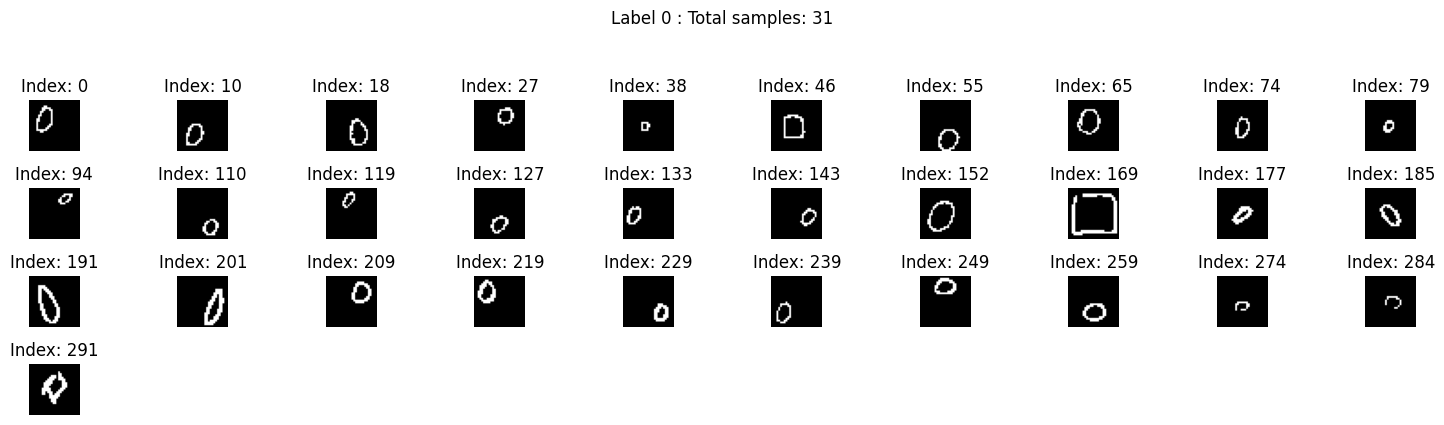

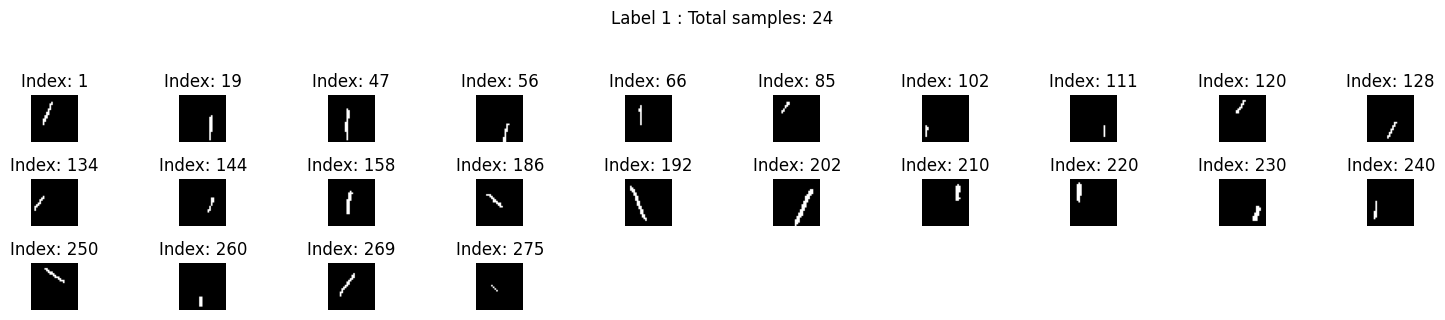

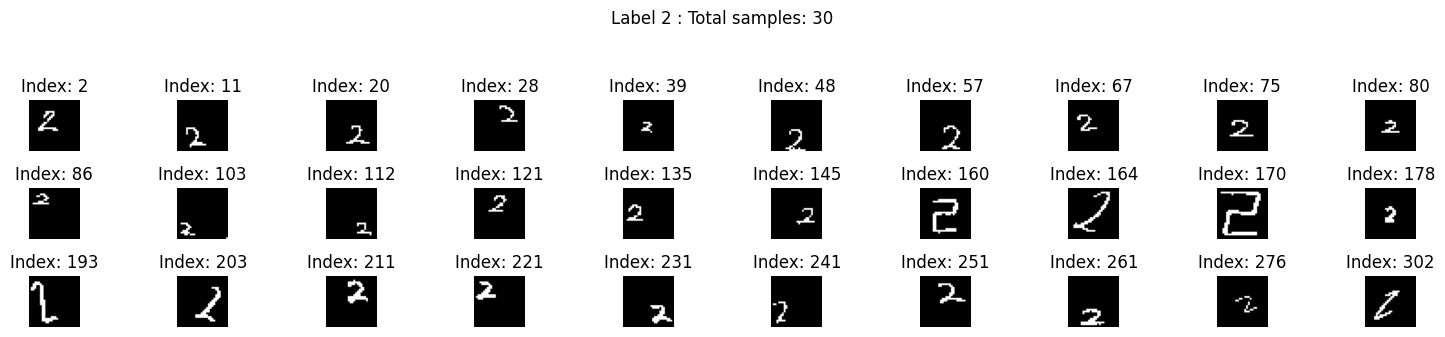

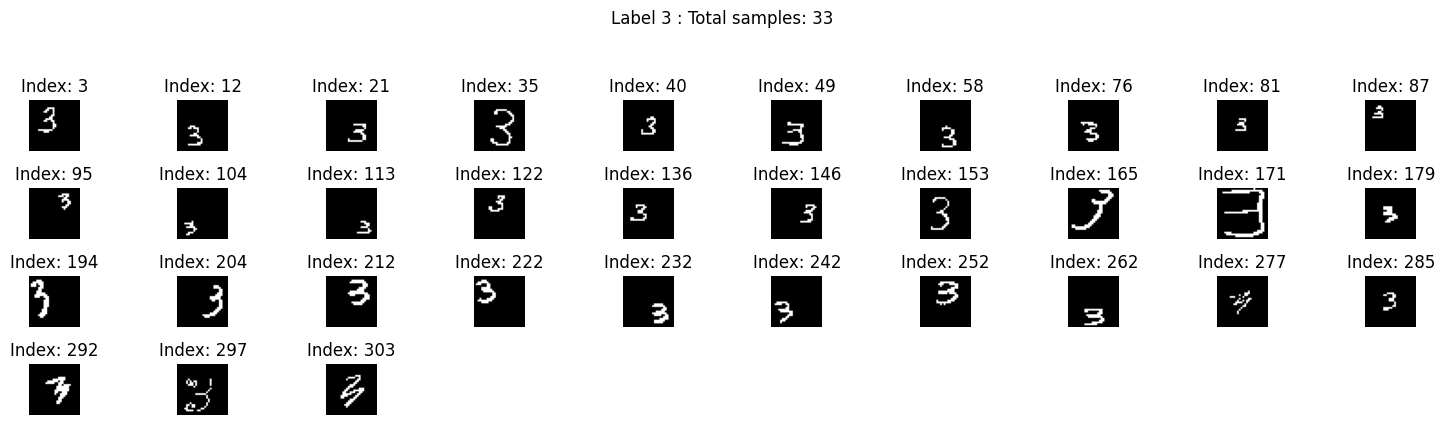

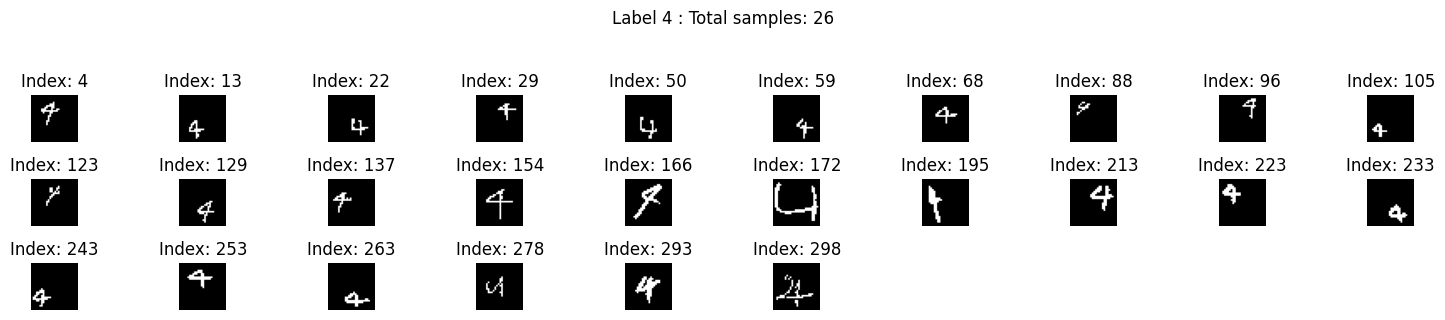

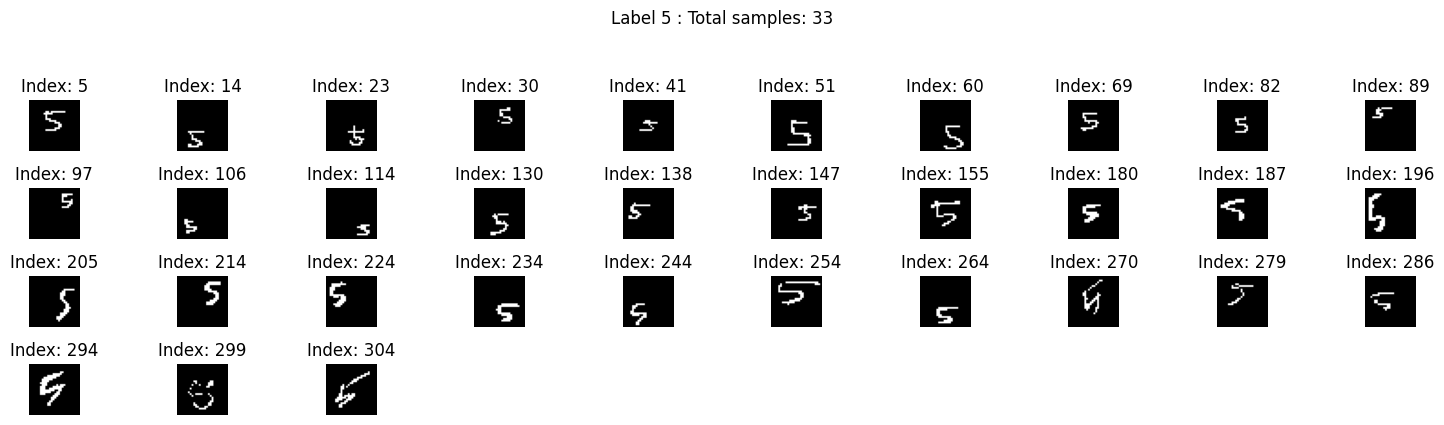

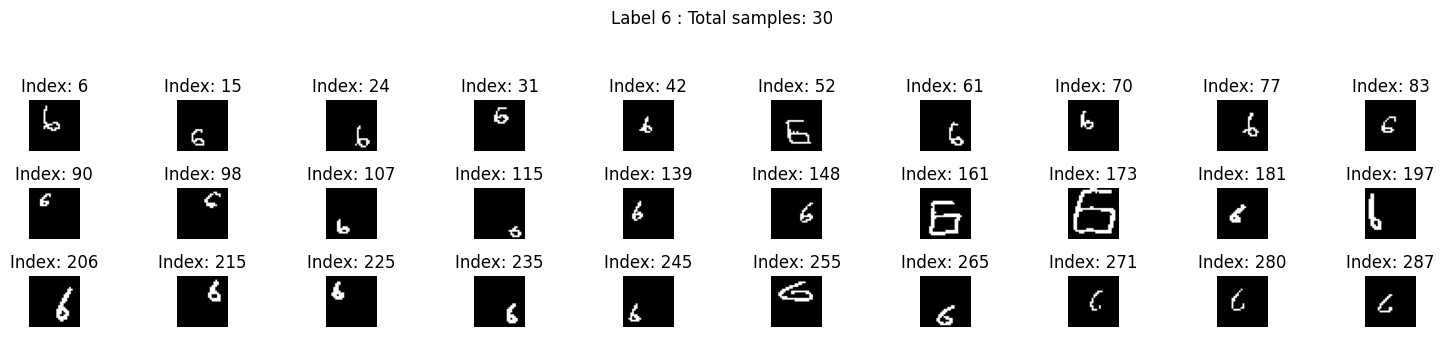

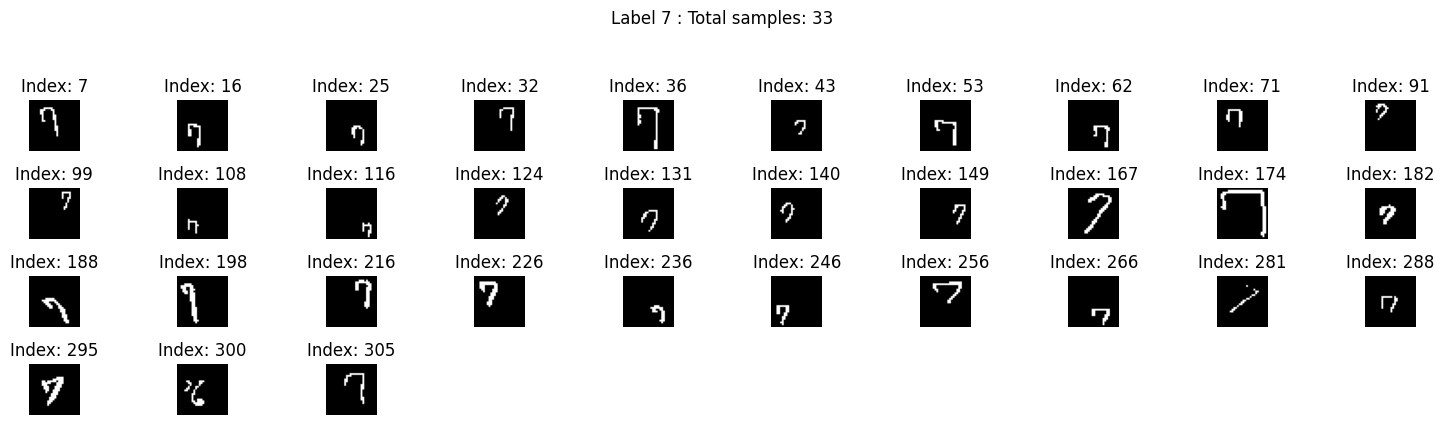

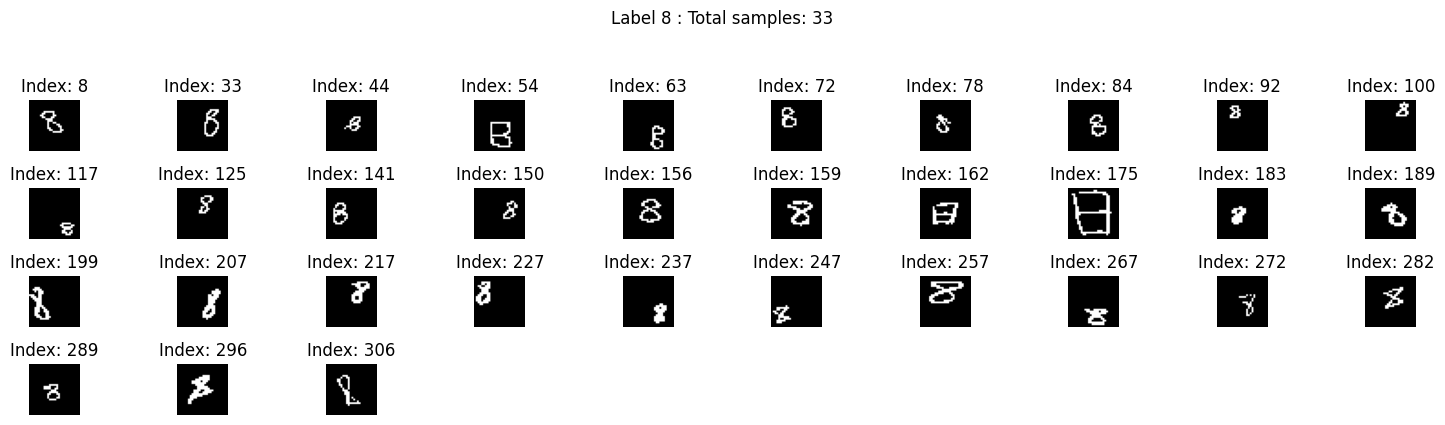

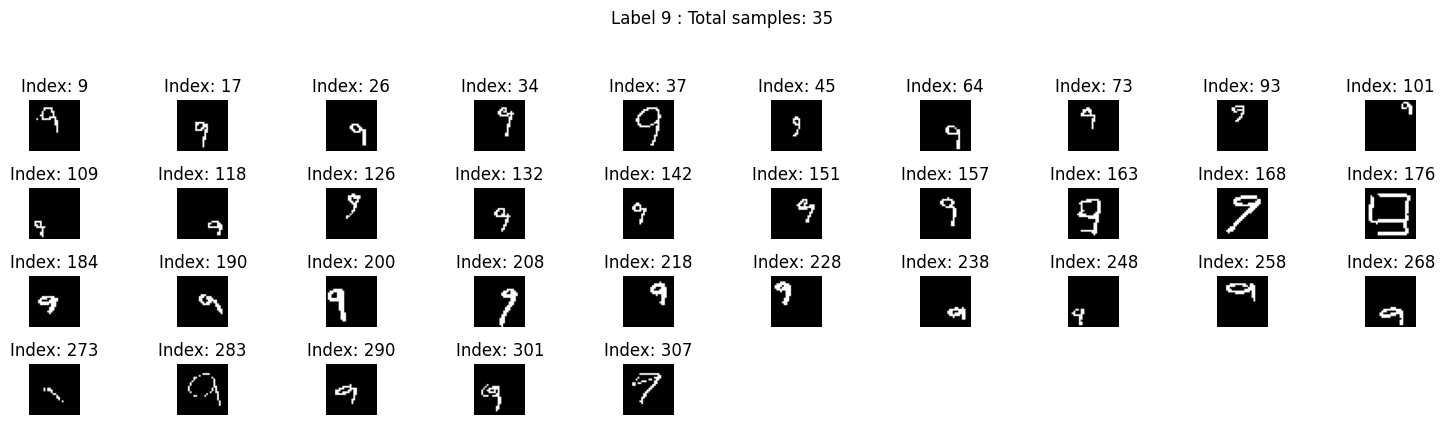

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
# 1. KNN 모델 생성
knn_clf = KNeighborsClassifier()

# KNN 모델 학습

knn_pipeline = Pipeline([
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('knn', KNeighborsClassifier())  # KNN 모델
])
start_time = time.time()
knn_pipeline.fit(o_X_train, o_y_train)
end_time = time.time()

# 에측
predictions1 = knn_pipeline.predict(o_X_test)
predictions2 = knn_pipeline.predict(t_X_test)

# 정확도 평가
accuracy1 = accuracy_score(o_y_test, predictions1)
accuracy2 = accuracy_score(t_y_test, predictions2)

print("Orginal Test accuracy: ", accuracy1)
print("Handmade Team Test accuracy: ", accuracy2)

wrong_indices1 = np.where(predictions1 != o_y_test)[0]
wrong_indices2 = np.where(predictions2 != t_y_test)[0]

# X_train, y_train을 사용하여 함수를 호출합니다.
show_all_images_by_label(t_X_test[wrong_indices2], t_y_test[wrong_indices2])

## 3-2. Handmade MNIST로 학습 // Original Test 틀린 예측 분석
- o_X_test: 지극히 정상인거 식별 X -> 필체 부족 (데이터 부족)

Orginal Test accuracy:  0.6890714285714286
Handmade Team Test accuracy:  0.415


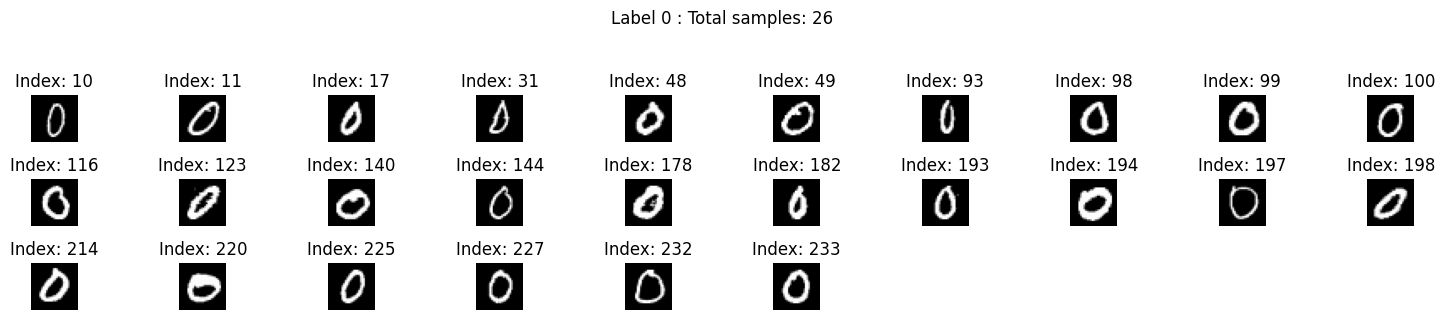

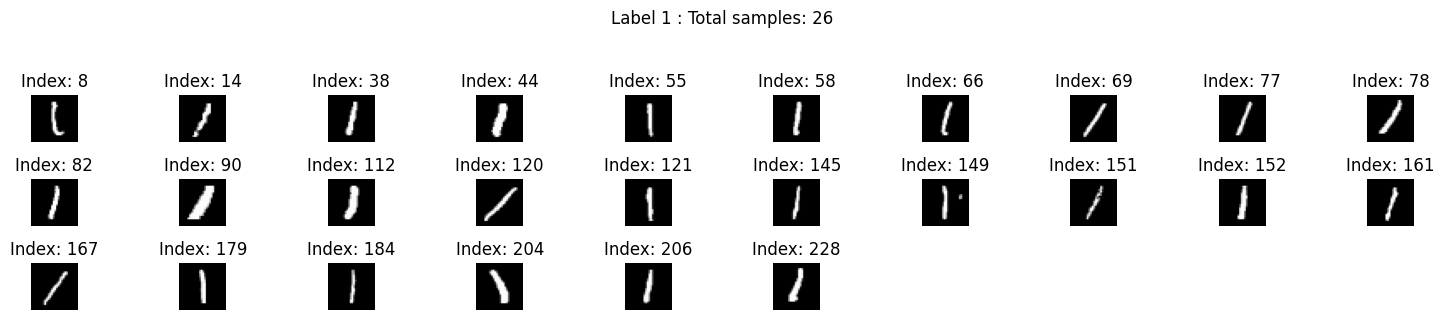

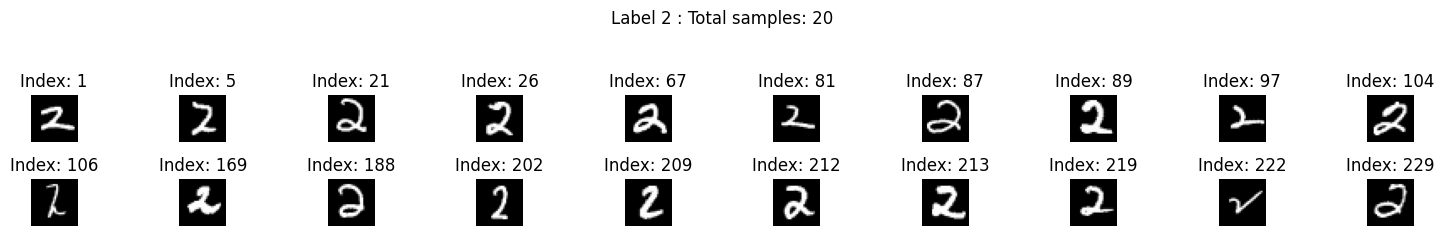

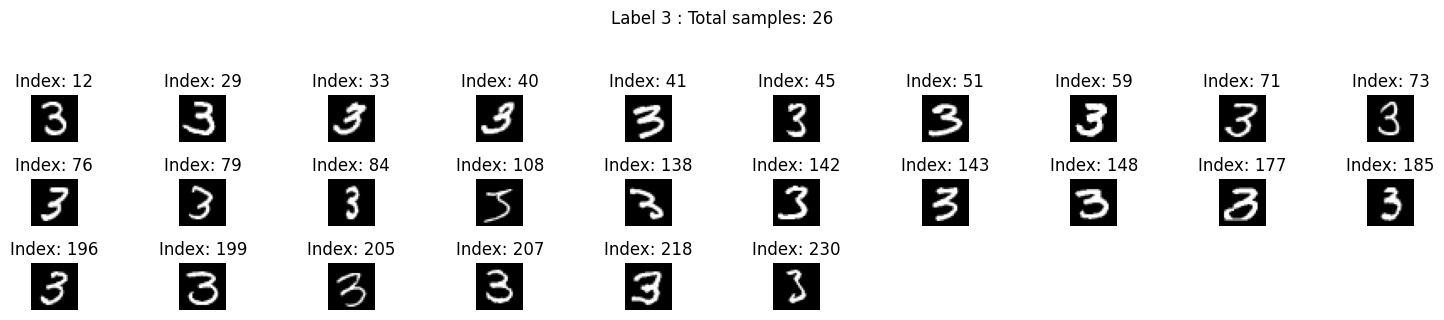

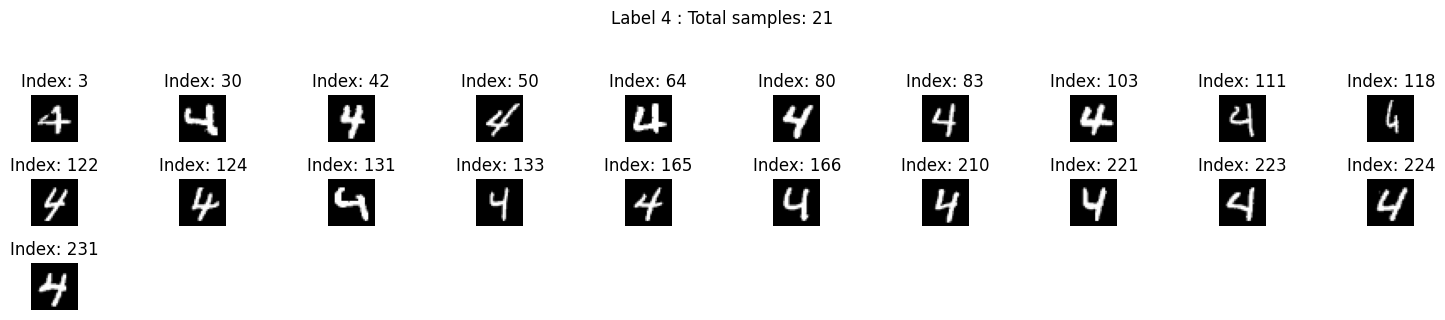

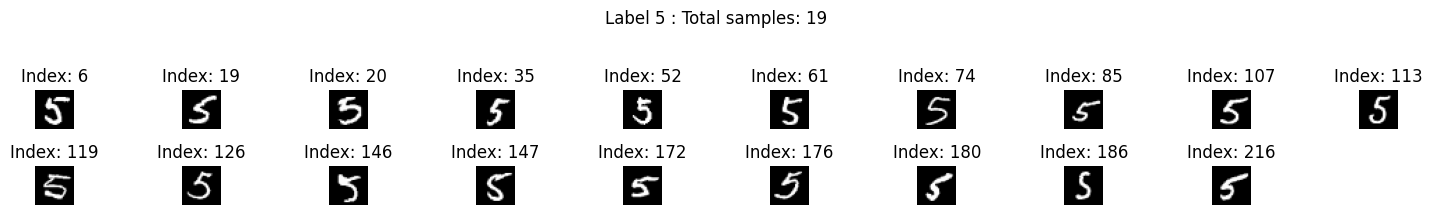

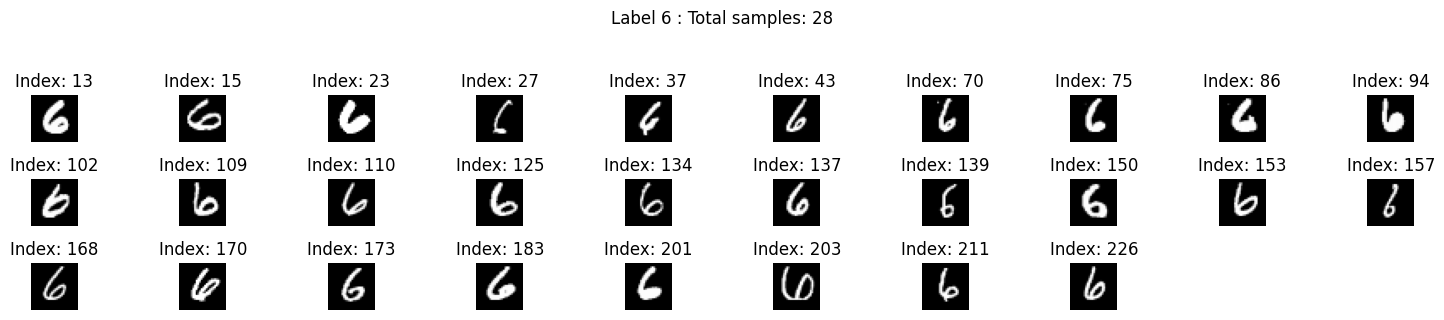

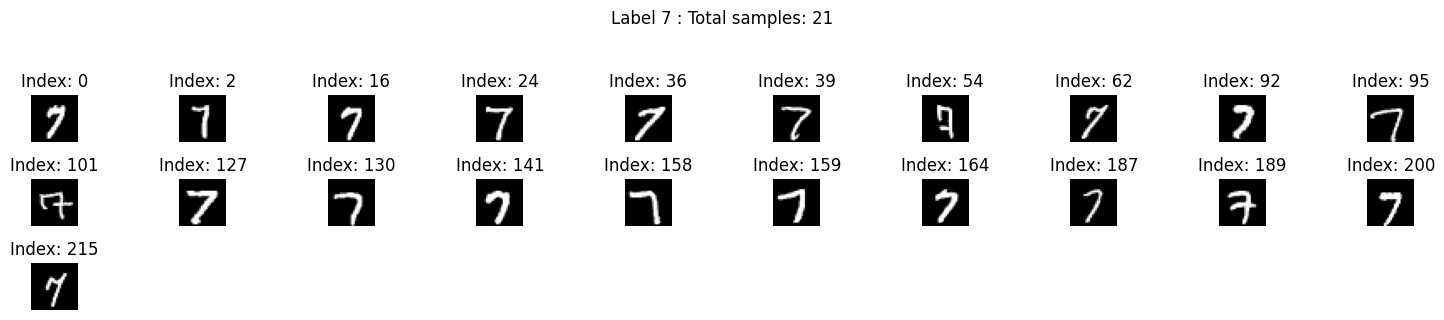

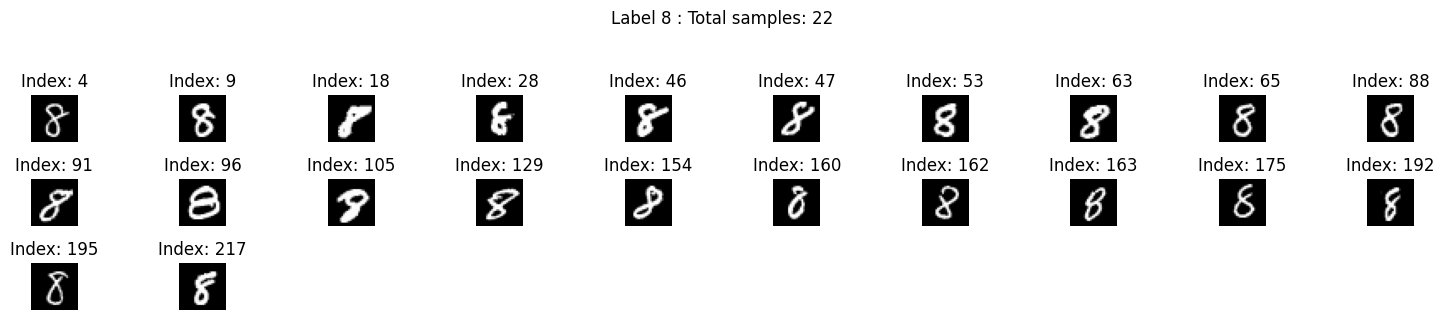

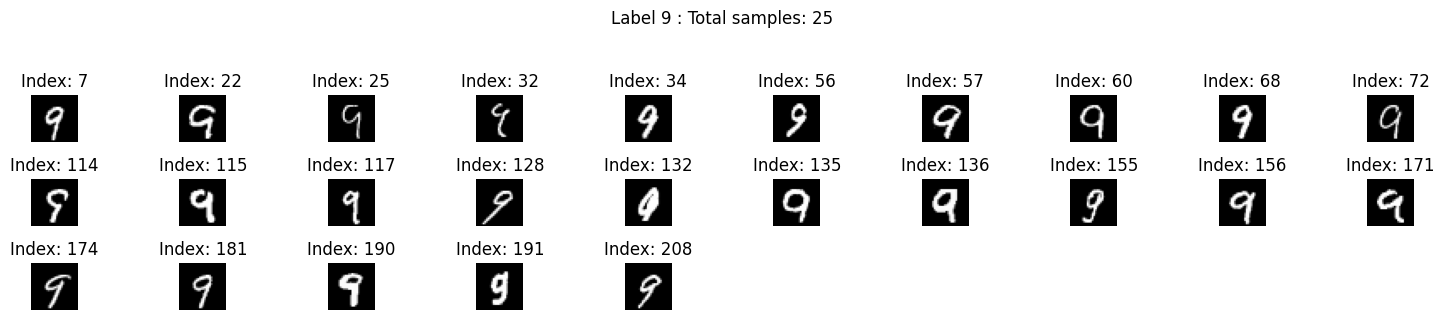

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
# 1. KNN 모델 생성
knn_clf = KNeighborsClassifier()

# KNN 모델 학습

knn_pipeline = Pipeline([
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('knn', KNeighborsClassifier())  # KNN 모델
])
start_time = time.time()
knn_pipeline.fit(X_train_10, y_train_10)
end_time = time.time()

# 에측
predictions1 = knn_pipeline.predict(o_X_test)
predictions2 = knn_pipeline.predict(t_X_test)

# 정확도 평가
accuracy1 = accuracy_score(o_y_test, predictions1)
accuracy2 = accuracy_score(t_y_test, predictions2)

print("Orginal Test accuracy: ", accuracy1)
print("Handmade Team Test accuracy: ", accuracy2)

wrong_indices1 = np.where(predictions1 != o_y_test)[0]
wrong_indices2 = np.where(predictions2 != t_y_test)[0]

show_all_images_by_label(o_X_test[wrong_indices2], o_y_test[wrong_indices2])

## 3-3. Combined MNIST로 학습 // Handmade, Original Test 틀린 예측 분석
- o_X_test: 정상 데이터에 대해서는 내성이 생김
- t_X_test: 여전히 작은 글씨 shifted 에 대해서 식별 X

Orginal Test accuracy:  0.9751428571428571
Handmade Team Test accuracy:  0.43


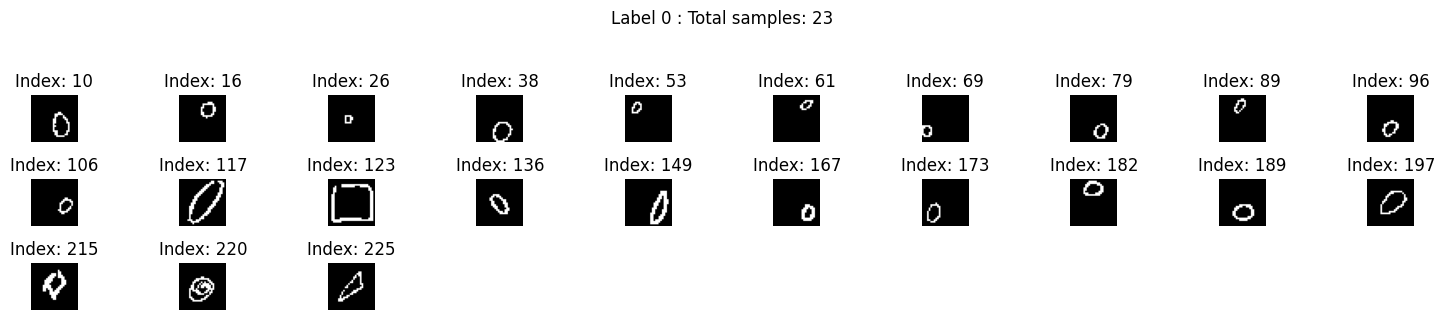

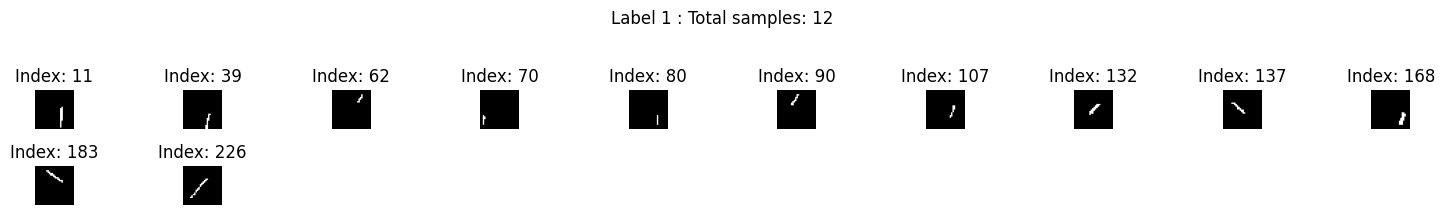

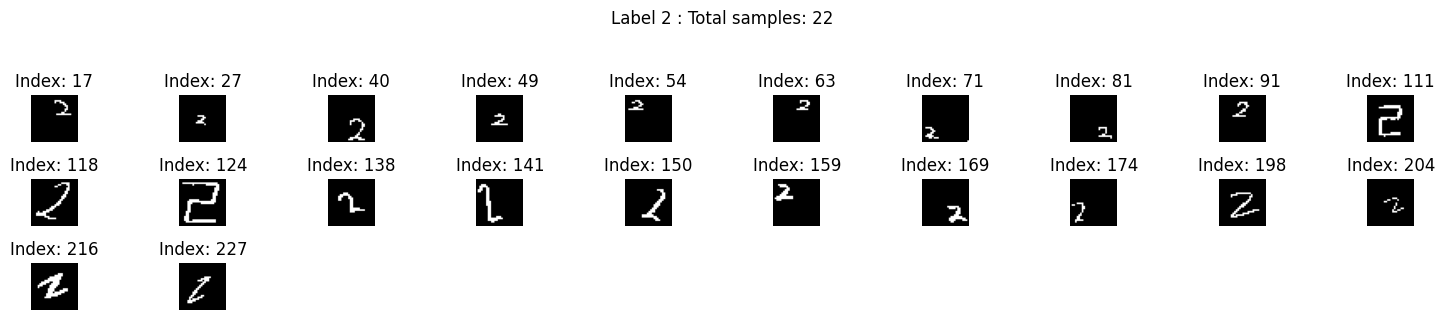

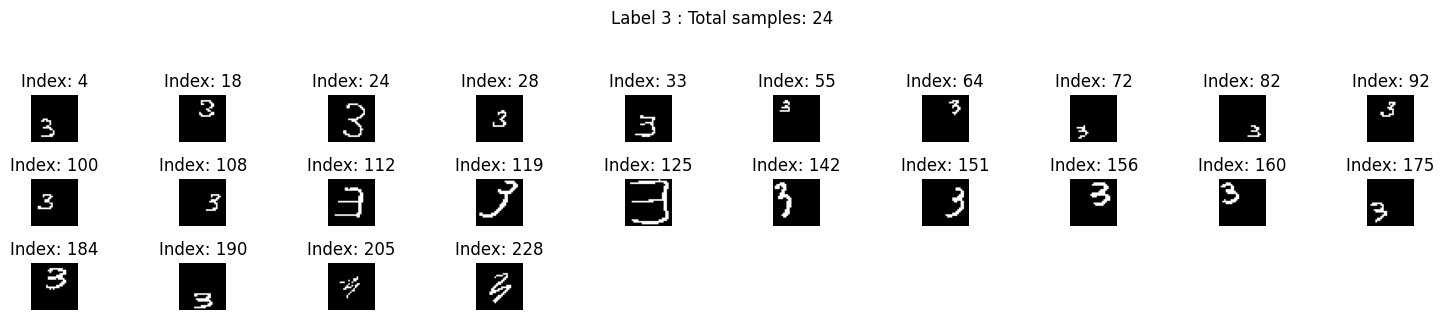

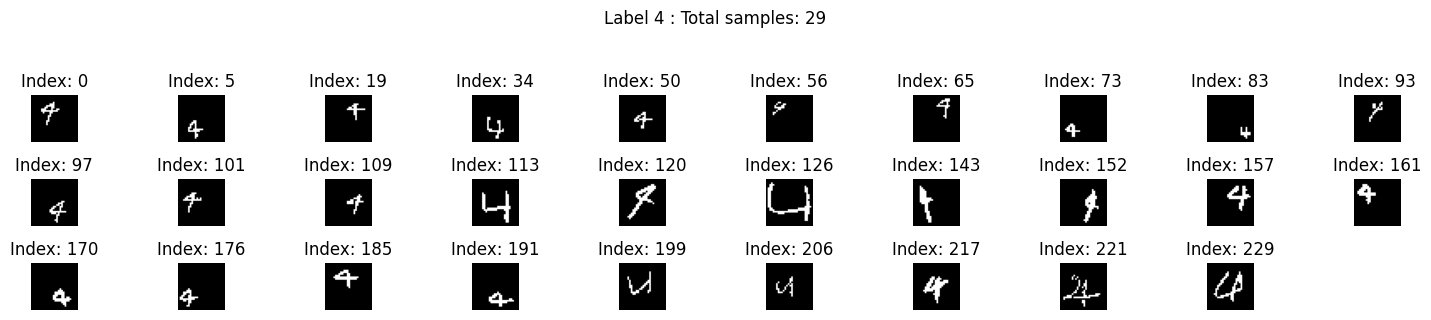

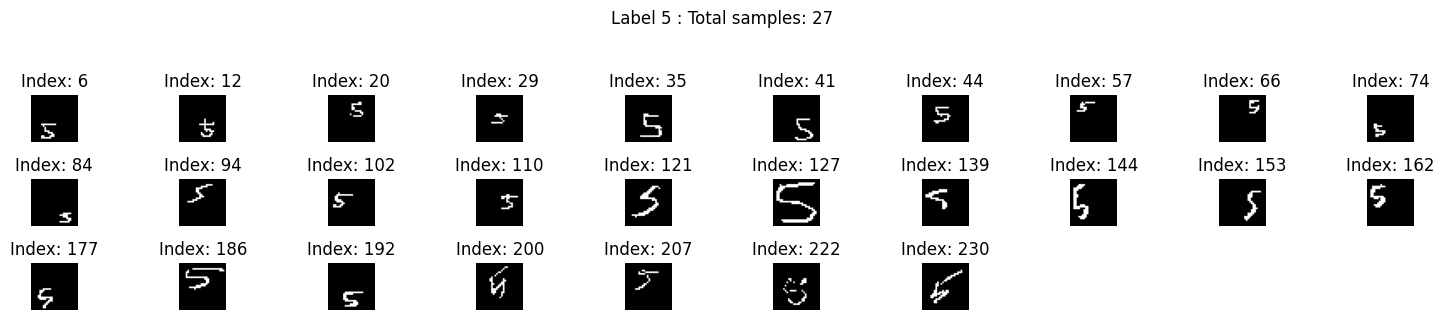

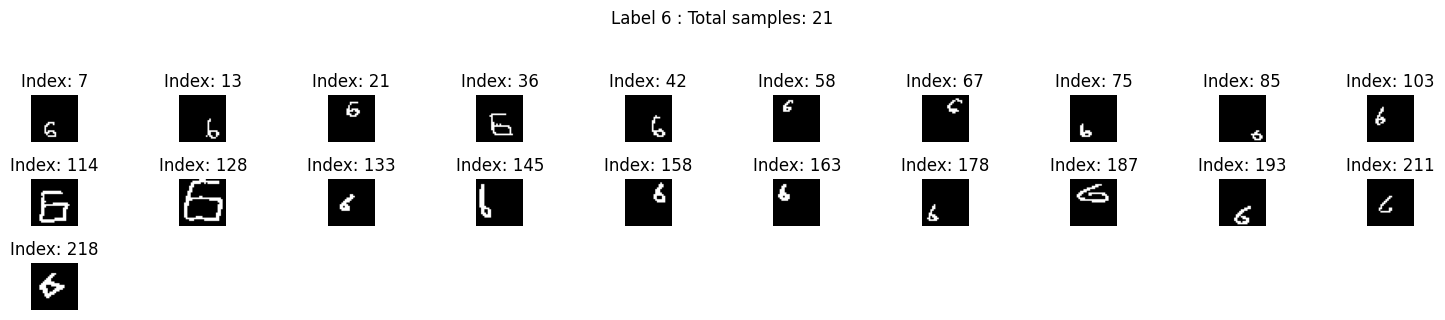

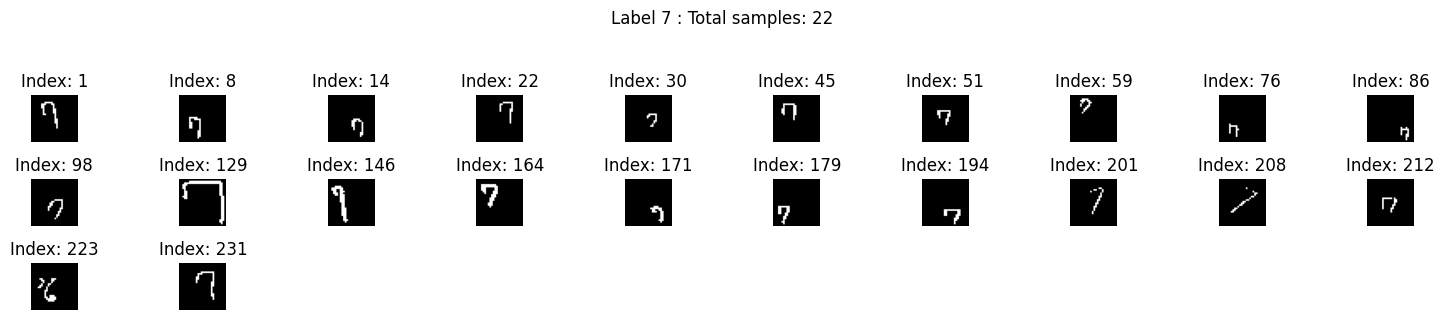

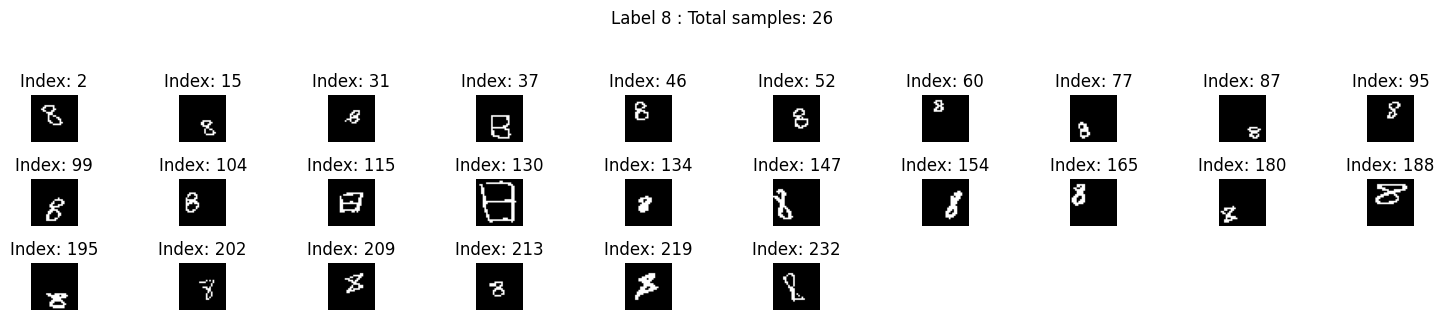

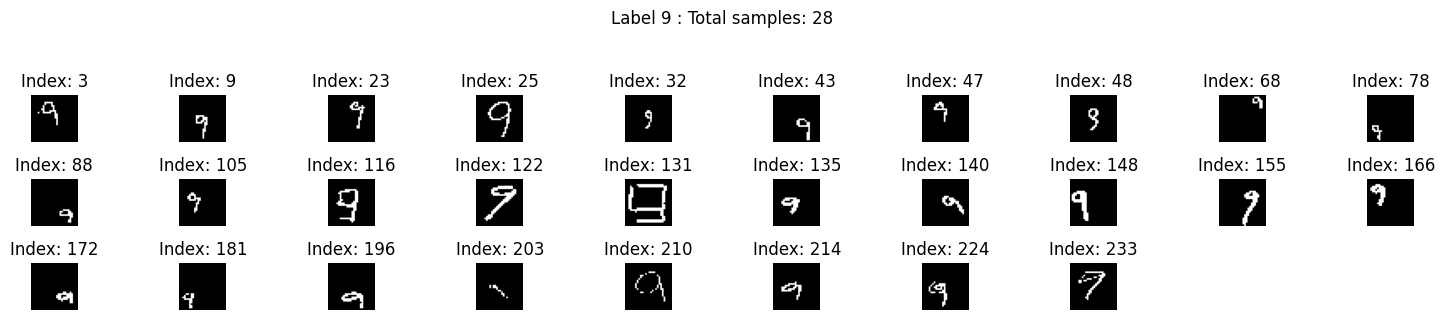

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
# 1. KNN 모델 생성
knn_clf = KNeighborsClassifier()

# KNN 모델 학습

knn_pipeline = Pipeline([
    ('normalizer', Normalizer()),  # 데이터 정규화
    ('knn', KNeighborsClassifier())  # KNN 모델
])
start_time = time.time()
knn_pipeline.fit(c_X_train_10, c_y_train_10)
end_time = time.time()

# 에측
predictions1 = knn_pipeline.predict(o_X_test)
predictions2 = knn_pipeline.predict(t_X_test)

# 정확도 평가
accuracy1 = accuracy_score(o_y_test, predictions1)
accuracy2 = accuracy_score(t_y_test, predictions2)

print("Orginal Test accuracy: ", accuracy1)
print("Handmade Team Test accuracy: ", accuracy2)

show_all_images_by_label(t_X_test[wrong_indices2], t_y_test[wrong_indices2])

# [EOF]